In [1]:
# Implement basic speech recognition using Whisper

# Install required packages
!pip install -q openai-whisper torch torchaudio transformers matplotlib ipython

import torch
import torchaudio
import whisper
import matplotlib.pyplot as plt
import numpy as np
from transformers import pipeline
import IPython
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

# Version information
print(f"PyTorch version: {torch.__version__}")
print(f"Torchaudio version: {torchaudio.__version__}")
print(f"Whisper version: {whisper.__version__}")

# Set random seed for reproducibility
torch.random.manual_seed(42)
np.random.seed(42)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 20.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/

In [2]:
# Load Whisper model
# Try different model sizes and compare results
model_size = "base"  # You can experiment with: tiny, base, small, medium, large
model = whisper.load_model(model_size, device=device)

print(f"Loaded Whisper {model_size} model")
print(f"Model device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Display model architecture overview
print(f"\nWhisper {model_size} Architecture:")
print(model)

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 74.0MiB/s]


Loaded Whisper base model
Model device: cpu
Model parameters: 71,825,920

Whisper base Architecture:
Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-5): 6 x ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (key): Linear(in_features=512, out_features=512, bias=False)
          (value): Linear(in_features=512, out_features=512, bias=True)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (attn_ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (mlp_ln): LayerNorm(

In [3]:
# Install transformers if not already available
# !pip install transformers torch sentencepiece

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import torch

def setup_translation_models(model_name="facebook/nllb-200-distilled-600M"):
    """
    Set up NLLB translation models for multiple language pairs

    Args:
        model_name: NLLB model variant to use

    Returns:
        Dictionary of translation pipelines
    """

    print(f"🔧 Setting up NLLB Translation Models:")
    print(f"   Model: {model_name}")
    print(f"   Loading tokenizer and model...")

    # Load model and tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

        print(f"   ✅ Model loaded successfully")
        print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")

        # Move to GPU if available
        if torch.cuda.is_available():
            model = model.to("cuda")
            print(f"   📱 Model moved to GPU")

    except Exception as e:
        print(f"   ❌ Error loading model: {e}")
        return None

    # Define common language pairs
    language_pairs = {
        'en_to_fr': {'src': 'eng_Latn', 'tgt': 'fra_Latn', 'name': 'English → French'},
        'en_to_es': {'src': 'eng_Latn', 'tgt': 'spa_Latn', 'name': 'English → Spanish'},
        'en_to_de': {'src': 'eng_Latn', 'tgt': 'deu_Latn', 'name': 'English → German'},
        'en_to_zh': {'src': 'eng_Latn', 'tgt': 'zho_Hans', 'name': 'English → Chinese (Simplified)'},
        'en_to_ja': {'src': 'eng_Latn', 'tgt': 'jpn_Jpan', 'name': 'English → Japanese'},
        'en_to_ar': {'src': 'eng_Latn', 'tgt': 'arb_Arab', 'name': 'English → Arabic'},
        'en_to_hi': {'src': 'eng_Latn', 'tgt': 'hin_Deva', 'name': 'English → Hindi'},
        'en_to_ru': {'src': 'eng_Latn', 'tgt': 'rus_Cyrl', 'name': 'English → Russian'},
    }

    # Create translation pipelines
    translators = {}

    print(f"\n🌍 Creating translation pipelines:")
    for pair_id, config in language_pairs.items():
        try:
            translator = pipeline(
                'translation',
                model=model,
                tokenizer=tokenizer,
                src_lang=config['src'],
                tgt_lang=config['tgt'],
                max_length=512,
                device=0 if torch.cuda.is_available() else -1
            )

            translators[pair_id] = {
                'pipeline': translator,
                'config': config
            }

            print(f"   ✅ {config['name']}")

        except Exception as e:
            print(f"   ❌ Failed to create {config['name']}: {e}")

    print(f"\n🎉 Created {len(translators)} translation pipelines")
    return translators

# Set up translation models
print("Initializing translation models...")
translation_models = setup_translation_models()

Initializing translation models...
🔧 Setting up NLLB Translation Models:
   Model: facebook/nllb-200-distilled-600M
   Loading tokenizer and model...


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


   ✅ Model loaded successfully
   Model parameters: 615,073,792

🌍 Creating translation pipelines:
   ✅ English → French
   ✅ English → Spanish
   ✅ English → German
   ✅ English → Chinese (Simplified)
   ✅ English → Japanese
   ✅ English → Arabic
   ✅ English → Hindi
   ✅ English → Russian

🎉 Created 8 translation pipelines


In [4]:
def test_translation_quality(translators, test_sentences=None):
    """
    Test translation quality across multiple languages

    Args:
        translators: Dictionary of translation pipelines
        test_sentences: List of test sentences

    Returns:
        Translation results
    """

    if test_sentences is None:
        test_sentences = [
            "Hello, how are you today?",
            "The weather is beautiful outside.",
            "I would like to order some food.",
            "Where is the nearest hospital?",
            "Thank you for your help.",
            "Machine learning is transforming technology."
        ]

    print("🧪 Translation Quality Testing:")
    print("=" * 35)

    results = {}

    for sentence in test_sentences:
        print(f"\n📝 Original: '{sentence}'")
        sentence_results = {}

        for pair_id, translator_info in translation_models.items():
            try:
                translator = translator_info['pipeline']
                config = translator_info['config']

                # Perform translation
                translation_result = translator(sentence)
                translated_text = translation_result[0]['translation_text']

                print(f"   {config['name']:20}: '{translated_text}'")

                sentence_results[pair_id] = {
                    'translation': translated_text,
                    'target_language': config['tgt'],
                    'language_name': config['name']
                }

            except Exception as e:
                print(f"   {config['name']:20}: ❌ Error - {e}")
                sentence_results[pair_id] = {'error': str(e)}

        results[sentence] = sentence_results

    return results

# Test translation quality if models are available
if translation_models:
    # [STUDENT ACTIVITY]: Students can add their own test sentences
    custom_test_sentences = [
        "Hello, how are you today?",
        "The weather is beautiful outside.",
        # Students add more sentences here
    ]

    translation_results = test_translation_quality(translation_models, custom_test_sentences)
else:
    print("⚠️ Translation models not available - skipping quality test")

🧪 Translation Quality Testing:

📝 Original: 'Hello, how are you today?'
   English → French    : 'Bonjour, comment allez-vous aujourd'hui ?'
   English → Spanish   : 'Hola, ¿cómo estás hoy?'
   English → German    : 'Hallo, wie geht's heute?'
   English → Chinese (Simplified): '您好,今天您怎么样?'
   English → Japanese  : 'こんにちは 今日はどうですか?'
   English → Arabic    : 'مرحباً، كيف حالك اليوم؟'
   English → Hindi     : 'हैलो, तुम आज कैसे हो?'
   English → Russian   : 'Здравствуйте, как вы сегодня?'

📝 Original: 'The weather is beautiful outside.'
   English → French    : 'Le temps est beau dehors.'
   English → Spanish   : 'El tiempo es hermoso afuera.'
   English → German    : 'Das Wetter draußen ist schön.'
   English → Chinese (Simplified): '外面天气很漂亮.'
   English → Japanese  : '外は天気が美しい.'
   English → Arabic    : 'الطقس جميل بالخارج'
   English → Hindi     : 'बाहर मौसम खूबसूरत है।'
   English → Russian   : 'На улице прекрасная погода.'


In [5]:
def load_and_preprocess_audio(file_path, target_sr=16000):
    """
    Load and preprocess audio for Whisper

    Args:
        file_path: Path to audio file
        target_sr: Target sample rate (Whisper expects 16kHz)

    Returns:
        waveform: Preprocessed audio tensor
        sample_rate: Sample rate
    """

    try:
        # Load audio file
        waveform, original_sr = torchaudio.load(file_path)
        print(f"✅ Loaded audio: {file_path}")
        print(f"   Original shape: {waveform.shape}")
        print(f"   Original sample rate: {original_sr} Hz")
        print(f"   Duration: {waveform.shape[1] / original_sr:.2f} seconds")

        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
            print(f"   Converted to mono")

        # Resample if necessary
        if original_sr != target_sr:
            waveform = torchaudio.functional.resample(
                waveform, orig_freq=original_sr, new_freq=target_sr
            )
            print(f"   Resampled to {target_sr} Hz")

        # Normalize audio (Whisper expects normalized input)
        waveform = waveform / torch.max(torch.abs(waveform))

        print(f"   Final shape: {waveform.shape}")
        print(f"   Audio range: [{waveform.min():.3f}, {waveform.max():.3f}]")

        return waveform.squeeze().numpy(), target_sr

    except Exception as e:
        print(f"❌ Error loading audio: {e}")
        return None, None

Part1

In [6]:
# Extract audio from video files

# !pip install moviepy

from moviepy.editor import VideoFileClip
import os

def extract_audio(video_path, output_audio_path=None):
    """
    从视频中提取音频并保存为 .wav 文件

    参数：
        video_path: 输入视频文件路径
        output_audio_path: 输出音频文件路径，默认与视频同名

    返回：
        音频文件保存路径
    """
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"找不到视频文件：{video_path}")

    if output_audio_path is None:
        output_audio_path = os.path.splitext(video_path)[0] + ".wav"

    video = VideoFileClip(video_path)
    video.audio.write_audiofile(output_audio_path)
    print(f"音频提取完成，保存为：{output_audio_path}")
    return output_audio_path

audio_path = extract_audio("video01.mp4")



MoviePy - Writing audio in video01.wav


MoviePy - Done.
音频提取完成，保存为：video01.wav


In [7]:
def load_and_preprocess_audio(file_path, target_sr=16000):
    """
    Load and preprocess audio for Whisper

    Args:
        file_path: Path to audio file
        target_sr: Target sample rate (Whisper expects 16kHz)

    Returns:
        waveform: Preprocessed audio tensor
        sample_rate: Sample rate
    """

    try:
        # Load audio file
        waveform, original_sr = torchaudio.load(file_path)
        print(f"✅ Loaded audio: {file_path}")
        print(f"   Original shape: {waveform.shape}")
        print(f"   Original sample rate: {original_sr} Hz")
        print(f"   Duration: {waveform.shape[1] / original_sr:.2f} seconds")

        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
            print(f"   Converted to mono")

        # Resample if necessary
        if original_sr != target_sr:
            waveform = torchaudio.functional.resample(
                waveform, orig_freq=original_sr, new_freq=target_sr
            )
            print(f"   Resampled to {target_sr} Hz")

        # Normalize audio (Whisper expects normalized input)
        waveform = waveform / torch.max(torch.abs(waveform))

        print(f"   Final shape: {waveform.shape}")
        print(f"   Audio range: [{waveform.min():.3f}, {waveform.max():.3f}]")

        return waveform.squeeze().numpy(), target_sr

    except Exception as e:
        print(f"❌ Error loading audio: {e}")
        return None, None

In [8]:

# Try to load sample audio
try:

    audio_data, sample_rate = load_and_preprocess_audio(audio_path)
    audio_source = "Downloaded sample"

except Exception as e:
    print(f"Download failed: {e}")
    print("Creating synthetic speech-like signal for demonstration...")

    # Create a synthetic audio signal that resembles speech patterns
    sample_rate = 16000
    duration = 3.0
    t = np.linspace(0, duration, int(sample_rate * duration))

    # Create a signal with speech-like characteristics
    # Combine multiple frequencies to simulate formants
    signal = (0.3 * np.sin(2 * np.pi * 200 * t) +  # F1 (low frequency)
              0.2 * np.sin(2 * np.pi * 1000 * t) +  # F2 (mid frequency)
              0.1 * np.sin(2 * np.pi * 2500 * t))   # F3 (high frequency)

    # Add some amplitude modulation to simulate speech rhythm
    envelope = 0.5 * (1 + np.sin(2 * np.pi * 3 * t))
    audio_data = signal * envelope

    # Normalize
    audio_data = audio_data / np.max(np.abs(audio_data))

✅ Loaded audio: video01.wav
   Original shape: torch.Size([2, 5707863])
   Original sample rate: 44100 Hz
   Duration: 129.43 seconds
   Converted to mono
   Resampled to 16000 Hz
   Final shape: torch.Size([1, 2070880])
   Audio range: [-0.660, 1.000]


In [9]:
import re

def transcribe_with_whisper(model, audio_data, language=None, task="transcribe"):
    """
    Do Whisper transcription WITH timestamps so we can merge later.
    """
    print(f"🎙️ Starting {task} with Whisper...")
    print(f"   Language: {language if language else 'auto-detect'}")
    print(f"   Audio duration: {len(audio_data)/16000:.2f} seconds")

    result = model.transcribe(
        audio_data,
        language=language,
        task=task,
        verbose=False,
        word_timestamps=True,      # <— 关键：拿词级时间戳
        condition_on_previous_text=True
    )
    return result


def merge_into_sentences(result, max_gap=0.8):
    """
    把 Whisper 输出合并成“每段=完整一句话”。
    优先用词级时间戳重建；没有则按段合并。
    max_gap: 同一句里允许的最大相邻词静音间隔（秒）
    """
    sentence_end = re.compile(r'[.!?…]+$')
    merged = []

    # --- 跑词级方案 ---
    has_words = any('words' in s and s['words'] for s in result.get('segments', []))
    if has_words:
        cur_words = []
        for seg in result['segments']:
            for w in seg.get('words', []):
                # w = {'word': 'Hello', 'start': 0.1, 'end': 0.5}
                if not cur_words:
                    cur_words.append(w)
                    continue

                gap = w['start'] - cur_words[-1]['end']
                # 条件1：遇到句末标点；条件2：静音间隔太长——都认为要“收句”
                if sentence_end.search(cur_words[-1]['word'].strip()) or gap > max_gap:
                    text = " ".join(x['word'] for x in cur_words).strip()
                    merged.append({
                        'start': cur_words[0]['start'],
                        'end':   cur_words[-1]['end'],
                        'text':  re.sub(r'\s+', ' ', text)
                    })
                    cur_words = [w]
                else:
                    cur_words.append(w)

        if cur_words:
            text = " ".join(x['word'] for x in cur_words).strip()
            merged.append({
                'start': cur_words[0]['start'],
                'end':   cur_words[-1]['end'],
                'text':  re.sub(r'\s+', ' ', text)
            })
        return merged

    # --- 退化：按段合并 ---
    cur = None
    for seg in result.get('segments', []):
        if cur is None:
            cur = {'start': seg['start'], 'end': seg['end'], 'text': seg['text'].strip()}
            continue

        gap = seg['start'] - cur['end']
        if sentence_end.search(cur['text']) or gap > max_gap:
            merged.append(cur)
            cur = {'start': seg['start'], 'end': seg['end'], 'text': seg['text'].strip()}
        else:
            cur['end'] = seg['end']
            cur['text'] = (cur['text'] + ' ' + seg['text']).strip()

    if cur:
        merged.append(cur)
    return merged


# ---------- 用法 ----------
print("=" * 50)
print("BASIC SPEECH RECOGNITION")
print("=" * 50)

result = transcribe_with_whisper(model, audio_data, language=None, task="transcribe")

print("\n📝 Transcription Results:")
print(f"Detected language: {result.get('language', 'unknown')}")
print(f"Transcript (raw): '{result.get('text','').strip()}'")

sentences = merge_into_sentences(result, max_gap=0.8)

def hhmmss(t):
    h = int(t // 3600); m = int((t % 3600) // 60); s = int(t % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

print("\n=== Formatted (one sentence per segment) ===")
for s in sentences:
    print(f"[{hhmmss(s['start'])}] Speaker_A: {s['text']}")


BASIC SPEECH RECOGNITION
🎙️ Starting transcribe with Whisper...
   Language: auto-detect
   Audio duration: 129.43 seconds
Detected language: English


100%|██████████| 12943/12943 [00:52<00:00, 245.07frames/s]


📝 Transcription Results:
Detected language: en
Transcript (raw): 'No, I'm just kidding. That would be terrible. Hi, everyone. As I set up here, rather quietly, my name is Walker Stec. And I would like to talk to you guys about the connection between first impression and future relationship. Now, as I just stood up here, rather, er, oh my gosh, sorry. As I stood up here holding onto my index cards for dear life, you all did a little something called making a first impression. And it's not your fault. We all, oh my, I didn't get the clicker. Sorry, guys. Thank you. OK, so as humans, we form 10 to 20 images of what we think a person's personality is like, based on 15 seconds of conversation. Now, let's do the math. Not bad. Of these 10 to 20 images, let's say we meet two new people a day for seven days a week, that's about 200 new images that we have created of people just based on 200 seconds of conversation. Now, another fun fact. 85% of these images are going to be just dead wrong, no

Part2

In [10]:
import dlib
import cv2
import os
import re
import json
import glob
import numpy as np
import random
from pylab import *
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageChops, ImageEnhance
import logging
tf.get_logger().setLevel(logging.ERROR)

In [11]:
# get video folders in list
# expects each video in separate folder, with folder having the same name as the video
test_folders_list = ["video02.mp4"]   # ← 这里填你的单个视频文件名或绝对路径

(test_folders_list[0])

'video02.mp4'

In [12]:
import glob, os, cv2, json

# ① 收集全部 video02.mp4 文件
video_list   = ["video02.mp4"]   # 或 "videos/*.mp4"
parent_dir   = "extracted_faces"
os.makedirs(parent_dir, exist_ok=True)

# ② 载入 OpenCV DNN 模型
net = cv2.dnn.readNetFromCaffe("deploy.prototxt.txt","res10_300x300_ssd_iter_140000.caffemodel")

for vid_path in video_list:
    video_name = os.path.splitext(os.path.basename(vid_path))[0]   # 'video01'
    out_dir    = os.path.join(parent_dir, video_name)
    os.makedirs(out_dir, exist_ok=True)

    cap        = cv2.VideoCapture(vid_path)
    fps        = cap.get(cv2.CAP_PROP_FPS)
    interval   = int(fps * 2)                               # 每 2.5 秒抽 1 帧
    frame_id   = saved = 0
    meta       = []

    while cap.isOpened() and saved < 100:                           # 每视频最多 10 张
        ok, frame = cap.read()
        if not ok: break
        if frame_id % interval == 0:
            (h, w) = frame.shape[:2]
            blob   = cv2.dnn.blobFromImage(cv2.resize(frame,(300,300)),1.0,
                                           (300,300),(104.0,177.0,123.0))
            net.setInput(blob)
            dets   = net.forward()
            for idx in range(dets.shape[2]):
                if dets[0,0,idx,2] < 0.5: continue
                x1,y1,x2,y2 = (dets[0,0,idx,3:7]*[w,h,w,h]).astype(int)
                x1,y1 = max(x1-15,0), max(y1-15,0)
                x2,y2 = min(x2+15,w-1), min(y2+15,h-1)
                crop  = frame[y1:y2, x1:x2]
                if crop.size == 0: continue
                fname = f"{video_name}_{saved}.jpg"
                cv2.imwrite(os.path.join(out_dir,fname), cv2.resize(crop,(299,299)))
                meta.append({"file": fname, "time": frame_id/fps})
                saved += 1
                if saved >= 100: break
        frame_id += 1
    cap.release()
    json.dump(meta, open(os.path.join(out_dir,"faces_meta.json"),"w"), indent=2)
    print(f"✅ {video_name}: saved {saved} faces → {out_dir}")


✅ video02: saved 100 faces → extracted_faces/video02


In [ ]:
# Install required packages for face recognition, execute in terminal:
# pip install facenet-pytorch
# pip install 'opencv-python==4.9.0.80'
# pip install 'pandas==2.2.1'

In [13]:
# Import face recognition libraries
from facenet_pytorch import MTCNN, InceptionResnetV1
import cv2
from PIL import Image
import os
import pandas as pd

print("Face recognition libraries loaded successfully!")

Face recognition libraries loaded successfully!


In [14]:
# Initialize MTCNN face detector
mtcnn = MTCNN(
    image_size=160,        # Output size for detected faces
    margin=0,              # Margin around detected face
    min_face_size=20,      # Minimum face size to detect
    thresholds=[0.6, 0.7, 0.7],  # Detection thresholds for 3 stages
    factor=0.709,          # Scaling factor between levels
    post_process=True,     # Apply post-processing
    device=device
)

print("MTCNN face detector initialized")
print(f"Device: {device}")

MTCNN face detector initialized
Device: cpu


In [15]:
# Initialize face recognition model
face_recognizer = InceptionResnetV1(pretrained='vggface2').eval().to(device)

print("InceptionResnetV1 face recognizer loaded")
print(f"Model trained on: VGGFace2 dataset")
print(f"Output dimension: 512 (face embedding vector)")

  0%|          | 0.00/107M [00:00<?, ?B/s]

InceptionResnetV1 face recognizer loaded
Model trained on: VGGFace2 dataset
Output dimension: 512 (face embedding vector)


In [16]:
# Import necessary libraries
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import time

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

Using device: cpu


In [17]:
# Extract the test images dataset
import zipfile
import urllib.request

# Download test_images.zip if not available
def download_test_images():
    """Download and extract test images for face recognition demo"""
    try:
        # Try to unzip if already downloaded
        with zipfile.ZipFile('test_images.zip', 'r') as zip_ref:
            zip_ref.extractall()
        print("test_images.zip extracted successfully!")
        return True
    except FileNotFoundError:
        print("test_images.zip not found. Please upload the test_images.zip file to continue.")
        print("This file should contain celebrity face images organized in folders by person name.")
        return False

# Extract test images
success = download_test_images()

if success:
    # Create custom collate function for DataLoader
    def collate_fn(x):
        return x[0]

    # Load the face database using ImageFolder
    face_dataset = datasets.ImageFolder('test_images')

    # Create mapping from index to class name
    face_dataset.idx_to_class = {i: c for c, i in face_dataset.class_to_idx.items()}

    # Create data loader
    face_loader = DataLoader(face_dataset, collate_fn=collate_fn, num_workers=2)

    print(f"Face database loaded successfully!")
    print(f"Number of people in database: {len(face_dataset.classes)}")
    print(f"Total images: {len(face_dataset)}")
    print(f"People in database: {face_dataset.classes}")

    # Display database structure
    for person_name in face_dataset.classes:
        person_folder = os.path.join('test_images', person_name)
        if os.path.exists(person_folder):
            num_images = len([f for f in os.listdir(person_folder)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  {person_name}: {num_images} images")
else:
    print("Cannot proceed without test_images.zip. Please upload the file first.")

test_images.zip extracted successfully!
Face database loaded successfully!
Number of people in database: 2
Total images: 8
People in database: ['A', 'B']
  A: 4 images
  B: 4 images


In [18]:
# Process all images in the database to create face embeddings
def build_face_database(face_loader, mtcnn, face_recognizer):
    """
    Build face database by processing all images

    Returns:
        aligned_faces: Tensor of aligned face images
        names: List of corresponding person names
        embeddings: Face embeddings for database
    """

    print("Building face database...")
    print("Processing images with MTCNN face detection...")

    aligned_faces = []
    names = []

    # Process each image in the dataset
    for image, label in face_loader:
        # Get person name from label
        person_name = face_dataset.idx_to_class[label]

        # Detect and align face
        aligned_face, prob = mtcnn(image, return_prob=True)

        if aligned_face is not None:
            print(f'Face detected for {person_name} with probability: {prob:.4f}')
            aligned_faces.append(aligned_face)
            names.append(person_name)
        else:
            print(f'No face detected for {person_name}')

    if len(aligned_faces) == 0:
        print("No faces detected in any images!")
        return None, None, None

    # Convert to tensor for batch processing
    aligned_tensor = torch.stack(aligned_faces).to(device)

    print(f"\nGenerating face embeddings for {len(aligned_faces)} faces...")

    # Generate embeddings
    with torch.no_grad():
        embeddings = face_recognizer(aligned_tensor).detach().cpu()

    print(f"Face database built successfully!")
    print(f"Database contains {len(names)} face embeddings")
    print(f"Embedding dimension: {embeddings.shape[1]}")

    return aligned_tensor, names, embeddings

# Build the database if test images are available
if success and 'face_dataset' in locals():
    aligned_faces, database_names, database_embeddings = build_face_database(
        face_loader, mtcnn, face_recognizer
    )

    if database_embeddings is not None:
        print(f"\nDatabase Summary:")
        print(f"People in database: {set(database_names)}")
        print(f"Total face embeddings: {len(database_embeddings)}")
else:
    print("Skipping database creation - test_images.zip not available")

Building face database...
Processing images with MTCNN face detection...
Face detected for A with probability: 1.0000
Face detected for A with probability: 1.0000
Face detected for A with probability: 1.0000
Face detected for A with probability: 1.0000
Face detected for B with probability: 0.9998
Face detected for B with probability: 1.0000
Face detected for B with probability: 1.0000
Face detected for B with probability: 1.0000

Generating face embeddings for 8 faces...
Face database built successfully!
Database contains 8 face embeddings
Embedding dimension: 512

Database Summary:
People in database: {'B', 'A'}
Total face embeddings: 8


Face Similarity Matrix (lower values = more similar):


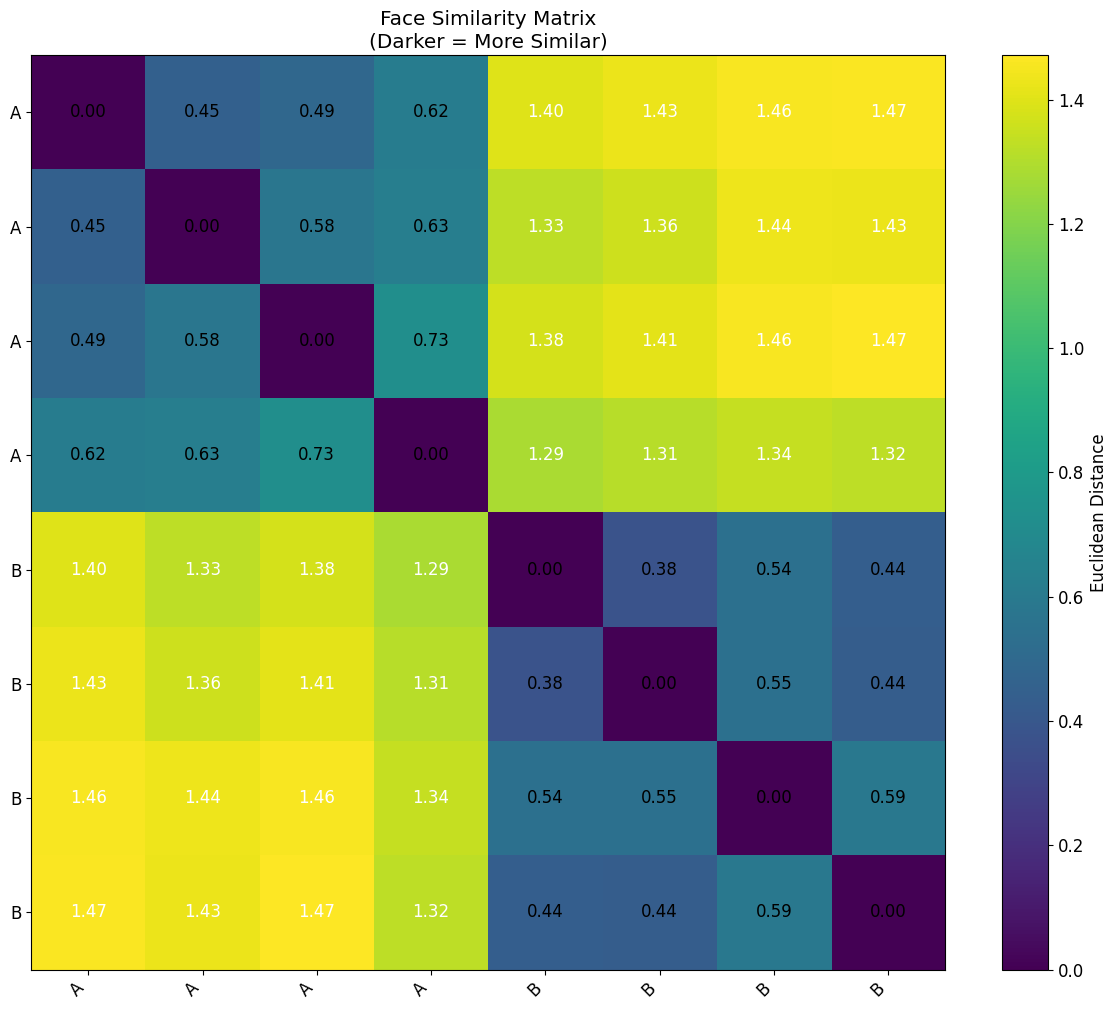


Similarity Analysis:
Most similar pair: ('B', 'B') (distance: 0.378)
Least similar pair: ('A', 'B') (distance: 1.471)


In [19]:
def analyze_face_similarities(embeddings, names):
    """Analyze similarities between faces in the database"""

    if embeddings is None or len(embeddings) == 0:
        print("No embeddings available for analysis")
        return

    # Calculate pairwise distances
    distances = []
    for i, emb1 in enumerate(embeddings):
        row_distances = []
        for j, emb2 in enumerate(embeddings):
            distance = torch.norm(emb1 - emb2).item()
            row_distances.append(distance)
        distances.append(row_distances)

    # Create distance matrix as DataFrame for better visualization
    distance_df = pd.DataFrame(distances, columns=names, index=names)

    print("Face Similarity Matrix (lower values = more similar):")
    print("=" * 60)

    # Visualize distance matrix
    plt.figure(figsize=(12, 10))

    # Create heatmap
    import numpy as np
    distance_matrix = np.array(distances)

    plt.imshow(distance_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Euclidean Distance')
    plt.title('Face Similarity Matrix\n(Darker = More Similar)')

    # Add labels
    plt.xticks(range(len(names)), names, rotation=45, ha='right')
    plt.yticks(range(len(names)), names)

    # Add distance values as text
    for i in range(len(names)):
        for j in range(len(names)):
            plt.text(j, i, f'{distance_matrix[i, j]:.2f}',
                    ha='center', va='center',
                    color='white' if distance_matrix[i, j] > np.max(distance_matrix)/2 else 'black')

    plt.tight_layout()
    plt.show()

    # Find most and least similar pairs
    min_distance = float('inf')
    max_distance = 0
    min_pair = None
    max_pair = None

    for i in range(len(names)):
        for j in range(i+1, len(names)):
            dist = distance_matrix[i, j]
            if dist < min_distance:
                min_distance = dist
                min_pair = (names[i], names[j])
            if dist > max_distance:
                max_distance = dist
                max_pair = (names[i], names[j])

    print(f"\nSimilarity Analysis:")
    print(f"Most similar pair: {min_pair} (distance: {min_distance:.3f})")
    print(f"Least similar pair: {max_pair} (distance: {max_distance:.3f})")

    return distance_df

# Analyze face similarities if we have embeddings
if 'database_embeddings' in locals() and database_embeddings is not None:
    similarity_matrix = analyze_face_similarities(database_embeddings, database_names)

In [20]:
def recognize_query_face(query_image_path, mtcnn, face_recognizer, database_embeddings, database_names, threshold=1.0):
    """
    Recognize a face from a query image

    Args:
        query_image_path: Path to query image
        mtcnn: Face detection model
        face_recognizer: Face recognition model
        database_embeddings: Known face embeddings
        database_names: Corresponding names
        threshold: Recognition threshold

    Returns:
        result_dict: Recognition results
    """
    try:

        # Load query image
        if isinstance(query_image_path, str):
            query_image = cv2.imread(query_image_path)
            if query_image is None:
                raise ValueError(f"Could not load image: {query_image_path}")
            # Convert BGR to RGB
            query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
            query_image = Image.fromarray(query_image)
        else:
            query_image = query_image_path  # Assume it's already a PIL Image

        print(f"Processing query image: {query_image_path}")

        # Detect face
        face_tensor, prob = mtcnn(query_image, return_prob=True)

        if face_tensor is None:
            return {
                'status': 'No face detected',
                'recognized_name': 'No Face',
                'confidence': 0.0,
                'distance': float('inf'),
                'query_image': query_image
            }

        print(f"Face detected with probability: {prob:.4f}")

        # Generate embedding
        face_tensor = face_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            query_embedding = face_recognizer(face_tensor).detach().cpu()

        # Compare with database
        distances = []
        for db_embedding in database_embeddings:
            distance = torch.norm(query_embedding - db_embedding).item()
            distances.append(distance)

        # Find best match
        min_distance = min(distances)
        best_match_idx = distances.index(min_distance)

        # Determine recognition result
        if min_distance < threshold:
            recognized_name = database_names[best_match_idx]
            confidence = max(0, 1.0 - (min_distance / threshold))
            status = 'Recognized'
        else:
            recognized_name = 'Unknown'
            confidence = 0.0
            status = 'Unknown person'

        result = {
            'status': status,
            'recognized_name': recognized_name,
            'confidence': confidence,
            'distance': min_distance,
            'all_distances': distances,
            'query_image': query_image,
            'detected_face': face_tensor.squeeze().cpu()
        }

        print(f"Result: {recognized_name} (distance: {min_distance:.3f}, confidence: {confidence:.3f})")

        return result

    except Exception as e:
        print(f"Error processing query: {str(e)}")
        return {
            'status': f'Error: {str(e)}',
            'recognized_name': 'Error',
            'confidence': 0.0,
            'distance': float('inf')
        }

In [21]:
from collections import defaultdict

def classify_extracted_faces(extracted_folder='extracted_faces/video02', threshold=1.0):
    """
    Recognize and group all extracted face images by identity

    Returns:
        grouped_faces: Dict of {recognized_name: [image_paths]}
    """
    grouped_faces = defaultdict(list)

    # 遍历文件夹
    for filename in os.listdir(extracted_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(extracted_folder, filename)

            result = recognize_query_face(
                image_path,
                mtcnn,
                face_recognizer,
                database_embeddings,
                database_names,
                threshold=threshold
            )

            name = result['recognized_name']
            grouped_faces[name].append(image_path)

    return grouped_faces


In [22]:
grouped_faces = classify_extracted_faces(threshold=1.0)

# 打印分组结果
print("\nGrouped Results:")
for person, images in grouped_faces.items():
    print(f"\n🧑 {person} ({len(images)} images):")
    for img in images:
        print(f"  - {img}")


Processing query image: extracted_faces/video02/video02_29.jpg
Face detected with probability: 0.9998
Result: A (distance: 0.701, confidence: 0.299)
Processing query image: extracted_faces/video02/video02_7.jpg
Face detected with probability: 1.0000
Result: A (distance: 0.589, confidence: 0.411)
Processing query image: extracted_faces/video02/video02_52.jpg
Face detected with probability: 1.0000
Result: B (distance: 0.524, confidence: 0.476)
Processing query image: extracted_faces/video02/video02_19.jpg
Face detected with probability: 1.0000
Result: A (distance: 0.508, confidence: 0.492)
Processing query image: extracted_faces/video02/video02_53.jpg
Face detected with probability: 1.0000
Result: A (distance: 0.605, confidence: 0.395)
Processing query image: extracted_faces/video02/video02_12.jpg
Face detected with probability: 0.9997
Result: B (distance: 0.395, confidence: 0.605)
Processing query image: extracted_faces/video02/video02_67.jpg
Face detected with probability: 0.9998
Resul

In [23]:
import os
import shutil

def save_grouped_faces(grouped_faces, output_root="grouped_output"):
    """Save grouped faces into subdirectories under output_root"""
    os.makedirs(output_root, exist_ok=True)

    for label, image_paths in grouped_faces.items():
        label_folder = os.path.join(output_root, label)
        os.makedirs(label_folder, exist_ok=True)

        for img_path in image_paths:
            # 复制图像到目标子文件夹
            filename = os.path.basename(img_path)
            dest_path = os.path.join(label_folder, filename)
            shutil.copy(img_path, dest_path)

    print(f"\n✅ All grouped images saved to '{output_root}'")

# 保存分组图像
save_grouped_faces(grouped_faces)



✅ All grouped images saved to 'grouped_output'


In [24]:
#load the audio from video02.mp4

audio_path_02 = extract_audio("video02.mp4")

# Try to load sample audio
try:

    audio_data, sample_rate = load_and_preprocess_audio(audio_path_02)
    audio_source = "Downloaded sample video02"

except Exception as e:
    print(f"Download failed: {e}")
    print("Creating synthetic speech-like signal for demonstration...")

    # Create a synthetic audio signal that resembles speech patterns
    sample_rate = 16000
    duration = 3.0
    t = np.linspace(0, duration, int(sample_rate * duration))

    # Create a signal with speech-like characteristics
    # Combine multiple frequencies to simulate formants
    signal = (0.3 * np.sin(2 * np.pi * 200 * t) +  # F1 (low frequency)
              0.2 * np.sin(2 * np.pi * 1000 * t) +  # F2 (mid frequency)
              0.1 * np.sin(2 * np.pi * 2500 * t))   # F3 (high frequency)

    # Add some amplitude modulation to simulate speech rhythm
    envelope = 0.5 * (1 + np.sin(2 * np.pi * 3 * t))
    audio_data = signal * envelope

    # Normalize
    audio_data = audio_data / np.max(np.abs(audio_data))

MoviePy - Writing audio in video02.wav


MoviePy - Done.
音频提取完成，保存为：video02.wav
✅ Loaded audio: video02.wav
   Original shape: torch.Size([2, 6313797])
   Original sample rate: 44100 Hz
   Duration: 143.17 seconds
   Converted to mono
   Resampled to 16000 Hz
   Final shape: torch.Size([1, 2290720])
   Audio range: [-0.890, 1.000]


In [25]:
import re

def transcribe_with_whisper(model, audio_data, language=None, task="transcribe"):
    """
    Do Whisper transcription WITH timestamps so we can merge later.
    """
    print(f"🎙️ Starting {task} with Whisper...")
    print(f"   Language: {language if language else 'auto-detect'}")
    print(f"   Audio duration: {len(audio_data)/16000:.2f} seconds")

    result = model.transcribe(
        audio_data,
        language=language,
        task=task,
        verbose=False,
        word_timestamps=True,      # <— 关键：拿词级时间戳
        condition_on_previous_text=True
    )
    return result


def merge_into_sentences(result, max_gap=0.8):
    """
    把 Whisper 输出合并成“每段=完整一句话”。
    优先用词级时间戳重建；没有则按段合并。
    max_gap: 同一句里允许的最大相邻词静音间隔（秒）
    """
    sentence_end = re.compile(r'[.!?…]+$')
    merged = []

    # --- 跑词级方案 ---
    has_words = any('words' in s and s['words'] for s in result.get('segments', []))
    if has_words:
        cur_words = []
        for seg in result['segments']:
            for w in seg.get('words', []):
                # w = {'word': 'Hello', 'start': 0.1, 'end': 0.5}
                if not cur_words:
                    cur_words.append(w)
                    continue

                gap = w['start'] - cur_words[-1]['end']
                # 条件1：遇到句末标点；条件2：静音间隔太长——都认为要“收句”
                if sentence_end.search(cur_words[-1]['word'].strip()) or gap > max_gap:
                    text = " ".join(x['word'] for x in cur_words).strip()
                    merged.append({
                        'start': cur_words[0]['start'],
                        'end':   cur_words[-1]['end'],
                        'text':  re.sub(r'\s+', ' ', text)
                    })
                    cur_words = [w]
                else:
                    cur_words.append(w)

        if cur_words:
            text = " ".join(x['word'] for x in cur_words).strip()
            merged.append({
                'start': cur_words[0]['start'],
                'end':   cur_words[-1]['end'],
                'text':  re.sub(r'\s+', ' ', text)
            })
        return merged

    # --- 退化：按段合并 ---
    cur = None
    for seg in result.get('segments', []):
        if cur is None:
            cur = {'start': seg['start'], 'end': seg['end'], 'text': seg['text'].strip()}
            continue

        gap = seg['start'] - cur['end']
        if sentence_end.search(cur['text']) or gap > max_gap:
            merged.append(cur)
            cur = {'start': seg['start'], 'end': seg['end'], 'text': seg['text'].strip()}
        else:
            cur['end'] = seg['end']
            cur['text'] = (cur['text'] + ' ' + seg['text']).strip()

    if cur:
        merged.append(cur)
    return merged


# ---------- 用法 ----------
print("=" * 50)
print("BASIC SPEECH RECOGNITION")
print("=" * 50)

result = transcribe_with_whisper(model, audio_data, language=None, task="transcribe")

print("\n📝 Transcription Results:")
print(f"Detected language: {result.get('language', 'unknown')}")
print(f"Transcript (raw): '{result.get('text','').strip()}'")

sentences = merge_into_sentences(result, max_gap=0.8)

def hhmmss(t):
    h = int(t // 3600); m = int((t % 3600) // 60); s = int(t % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

print("\n=== Formatted (one sentence per segment) ===")
for s in sentences:
    print(f"[{hhmmss(s['start'])}] Speaker_A: {s['text']}")


BASIC SPEECH RECOGNITION
🎙️ Starting transcribe with Whisper...
   Language: auto-detect
   Audio duration: 143.17 seconds
Detected language: English


100%|██████████| 14317/14317 [01:03<00:00, 225.93frames/s]


📝 Transcription Results:
Detected language: en
Transcript (raw): 'video we're going to cover how to do an interview with the host and a guest on camera at the same time. Now you can see we both have a little microphone on this, a lavalier microphone. We're running them into a Y splitter and then from that we're going into that KD connector that goes into the iPad, the iPhone, or whatever you're recording into. So I have with me today my guest is Keith Gilmore. Keith, could you tell us a little bit about yourself? Yeah, but a copywriter for the last seven years and basically helped to make the create the best messages that are the most compelling for my clients. So a copywriting thing is not a legal thing, it's more of a sales marketing. No, it's not the marketing scene with a little circle around it. Yeah, it's along the lines of all things marketing. Great, well thank you. So one of the things we're checking right here is the volume of how he speaks and how I speak and making sure we

In [26]:
import os

OUTPUT_DIR = "/content/sentences_out"  # 你想要保存的路径
os.makedirs(OUTPUT_DIR, exist_ok=True)  # exist_ok=True 表示如果已存在不会报错

print(f"✅ 文件夹已准备好：{OUTPUT_DIR}")

✅ 文件夹已准备好：/content/sentences_out


In [27]:
# --- (一次性) 依赖安装：在 Colab 可直接运行 ---
# !pip -q install pydub openai-whisper

import os, re, unicodedata, math
from pathlib import Path
from pydub import AudioSegment

try:
    import whisper  # 如果你已有 model 对象，可以忽略加载
except ImportError:
    pass

# ============== 配置区（根据你的情况修改） ==============
# 1) 如果你从“文件”开始，填路径（常见）：
INPUT_AUDIO = "/content/video02.wav"   # 支持 wav/mp3/m4a 等
OUTPUT_DIR  = "/content/sentences_out"

# 2) 如果你已经有 whisper 的 model 和 audio_data，可把下面两行设为 None，并使用你现成的对象
MODEL_SIZE  = "base"   # tiny/base/small/medium/large (根据你的显存和速度选择)
USE_FILE_INPUT = True  # True：走文件路径；False：使用你现成的 audio_data 变量
# =====================================================


def load_whisper_model(name="base"):
    print(f"🚀 Loading Whisper model: {name}")
    return whisper.load_model(name)


def transcribe_with_whisper(model, audio_source, language=None, task="transcribe"):
    """
    audio_source: 如果是 numpy 数组(16k 单声道)就直接传数组；如果是路径就传 str/path。
    """
    print(f"🎙️ Starting {task} with Whisper...")
    print(f"   Language: {language if language else 'auto-detect'}")

    result = model.transcribe(
        audio_source,
        language=language,
        task=task,
        verbose=False,
        word_timestamps=True,      # 关键：拿词级时间戳
        condition_on_previous_text=True
    )
    return result


def merge_into_sentences(result, max_gap=0.8):
    """
    把 Whisper 输出合并成“每段=完整一句话”。
    优先用词级时间戳重建；没有则按段合并。
    max_gap: 同一句里允许的最大相邻词静音间隔（秒）
    """
    sentence_end = re.compile(r'[.!?…]+$')
    merged = []

    # --- 跑词级方案 ---
    has_words = any('words' in s and s['words'] for s in result.get('segments', []))
    if has_words:
        cur_words = []
        for seg in result['segments']:
            for w in seg.get('words', []):
                # w = {'word': 'Hello', 'start': 0.1, 'end': 0.5}
                if not cur_words:
                    cur_words.append(w)
                    continue

                gap = w['start'] - cur_words[-1]['end']
                # 条件1：遇到句末标点；条件2：静音间隔太长——都认为要“收句”
                if sentence_end.search(cur_words[-1]['word'].strip()) or gap > max_gap:
                    text = " ".join(x['word'] for x in cur_words).strip()
                    merged.append({
                        'start': cur_words[0]['start'],
                        'end':   cur_words[-1]['end'],
                        'text':  re.sub(r'\s+', ' ', text)
                    })
                    cur_words = [w]
                else:
                    cur_words.append(w)

        if cur_words:
            text = " ".join(x['word'] for x in cur_words).strip()
            merged.append({
                'start': cur_words[0]['start'],
                'end':   cur_words[-1]['end'],
                'text':  re.sub(r'\s+', ' ', text)
            })
        return merged

    # --- 退化：按段合并 ---
    cur = None
    for seg in result.get('segments', []):
        if cur is None:
            cur = {'start': seg['start'], 'end': seg['end'], 'text': seg['text'].strip()}
            continue

        gap = seg['start'] - cur['end']
        if sentence_end.search(cur['text']) or gap > max_gap:
            merged.append(cur)
            cur = {'start': seg['start'], 'end': seg['end'], 'text': seg['text'].strip()}
        else:
            cur['end'] = seg['end']
            cur['text'] = (cur['text'] + ' ' + seg['text']).strip()

    if cur:
        merged.append(cur)
    return merged


def hhmmss(t):
    h = int(t // 3600); m = int((t % 3600) // 60); s = int(t % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"


def _safe_snippet(text, maxlen=40):
    # 用于文件名：去掉奇怪符号/控制字符/过长文本
    text = unicodedata.normalize("NFKC", text).strip()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9\u4e00-\u9fff _-]", "", text)  # 保留中英文字母、数字、空格、下划线、短横
    if len(text) > maxlen:
        text = text[:maxlen].rstrip()
    return text or "clip"


def save_sentence_clips(input_audio_path, sentences, out_dir, fmt="wav"):
    """
    用 pydub 按句裁切音频并保存。
    注意：如果你最初传给 whisper 的是数组，这里仍需要原始音频文件路径来读取波形。
    """
    os.makedirs(out_dir, exist_ok=True)
    audio = AudioSegment.from_file(input_audio_path)  # 自动识别格式

    saved_files = []
    for i, s in enumerate(sentences, start=1):
        start_ms = max(0, int(math.floor(s['start'] * 1000)))
        end_ms   = max(start_ms + 1, int(math.ceil(s['end'] * 1000)))  # 至少 1ms，避免空切片
        chunk = audio[start_ms:end_ms]

        # 构造更友好的文件名：编号_起止_文本片段.wav
        t1, t2 = hhmmss(s['start']).replace(":", "-"), hhmmss(s['end']).replace(":", "-")
        snippet = _safe_snippet(s['text'])
        fname = f"{i:03d}_{t1}_{t2}_{snippet}.{fmt}"
        fpath = str(Path(out_dir) / fname)

        chunk.export(fpath, format=fmt)
        saved_files.append(fpath)
    return saved_files


# ====================== 主流程 ======================
print("=" * 50)
print("BASIC SPEECH RECOGNITION + SENTENCE SPLITTING + CLIP SAVING")
print("=" * 50)



if USE_FILE_INPUT:
    # 从音频“文件”开始
    audio_source = INPUT_AUDIO
else:
    # 已有 16k 单声道 numpy 数组：audio_data
    # audio_source = audio_data  # ← 解注释并确保变量存在
    raise ValueError("请把 USE_FILE_INPUT 设为 True 或提供 audio_data 变量。")

# 转写
result = transcribe_with_whisper(model, audio_source, language=None, task="transcribe")

# print("\n📝 Transcription Results:")
# print(f"Detected language: {result.get('language', 'unknown')}")
# print(f"Transcript (raw): '{result.get('text','').strip()}'")

# 合并为“每句一段”
sentences = merge_into_sentences(result, max_gap=0.8)

# print("\n=== Formatted (one sentence per segment) ===")
# for s in sentences:
#     print(f"[{hhmmss(s['start'])}] Speaker_A: {s['text']}")

# 按句裁剪并保存
saved = save_sentence_clips(INPUT_AUDIO, sentences, OUTPUT_DIR, fmt="wav")
print(f"\n✅ Saved {len(saved)} sentence clips to: {OUTPUT_DIR}")
print("Example files:")
print("\n".join(saved[:5]))


BASIC SPEECH RECOGNITION + SENTENCE SPLITTING + CLIP SAVING
🎙️ Starting transcribe with Whisper...
   Language: auto-detect
Detected language: English


100%|██████████| 14317/14317 [00:54<00:00, 264.63frames/s]


✅ Saved 27 sentence clips to: /content/sentences_out
Example files:
/content/sentences_out/001_00-00-00_00-00-04_In this video were going to cover how to.wav
/content/sentences_out/002_00-00-05_00-00-08_Now you can see we both have a little mi.wav
/content/sentences_out/003_00-00-09_00-00-17_Were running them into a Y splitter and.wav
/content/sentences_out/004_00-00-18_00-00-22_So I have with me today my guest is Keit.wav
/content/sentences_out/005_00-00-22_00-00-23_Keith could you tell us a little bit abo.wav


In [28]:
!pip -q install resemblyzer soundfile librosa scikit-learn joblib

import os, glob, numpy as np
import soundfile as sf
import librosa
from pathlib import Path
from resemblyzer import VoiceEncoder, preprocess_wav
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from joblib import dump, load


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 24.3 MB/s eta 0:00:00


In [29]:
import zipfile
import os

# 要解压到的目标文件夹
os.makedirs("/content/VOICE", exist_ok=True)


# 解压 VOICE.zip
with zipfile.ZipFile("/content/VOICE.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/VOICE")


print("✅ 解压完成")


✅ 解压完成


In [30]:
ROOT = Path("/content/VOICE/VOICE")
A_DIR = ROOT / "A"
B_DIR = ROOT / "B"
assert A_DIR.exists() and B_DIR.exists(), "Make sure you already moved files into A/ and B/"


In [31]:
encoder = VoiceEncoder()  # CPU is fine; it'll just be slower

import librosa, soundfile as sf
import numpy as np
from resemblyzer import VoiceEncoder

encoder = VoiceEncoder()

def file_to_embedding(path: Path, target_sr=16000, min_len_sec=1.0):
    # 读文件，不用VAD
    sig, sr = sf.read(str(path), always_2d=False)
    if sig.ndim > 1:
        sig = sig.mean(axis=1)
    if sr != target_sr:
        sig = librosa.resample(sig.astype(np.float32), orig_sr=sr, target_sr=target_sr)
    else:
        sig = sig.astype(np.float32)

    # 正常化
    m = np.max(np.abs(sig)) or 1.0
    sig = sig / m

    # 补零到至少 min_len_sec
    min_len = int(min_len_sec * target_sr)
    if len(sig) < min_len:
        sig = np.pad(sig, (0, min_len - len(sig)))

    emb = encoder.embed_utterance(sig)
    return emb.astype(np.float32)



Loaded the voice encoder model on cpu in 0.02 seconds.
Loaded the voice encoder model on cpu in 0.02 seconds.


In [32]:
X, y, fnames = [], [], []

for label, d in [(0, A_DIR), (1, B_DIR)]:
    for f in sorted(glob.glob(str(d / "*"))):
        emb = file_to_embedding(Path(f))
        if emb is None:
            continue
        X.append(emb); y.append(label); fnames.append(f)

X = np.vstack(X)
y = np.array(y)
print("Embeddings:", X.shape, " A:", (y==0).sum(), " B:", (y==1).sum())


Embeddings: (6, 256)  A: 3  B: 3


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline: standardize → classifier
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, n_jobs=1)
)
# Alternative:
# clf = make_pipeline(StandardScaler(), SVC(kernel="linear", probability=True))

clf.fit(X_train, y_train)
print("Train acc:", clf.score(X_train, y_train))
print("Test  acc:", clf.score(X_test, y_test))

# Quick CV check (optional)
scores = cross_val_score(clf, X, y, cv=3)
print("3-fold CV acc:", scores.mean().round(4), "±", scores.std().round(4))

# Save model + label map
dump(clf, ROOT / "ab_classifier.joblib")
np.save(ROOT / "label_map.npy", np.array(["A","B"]))
print("✅ Saved:", ROOT / "ab_classifier.joblib")


Train acc: 1.0
Test  acc: 1.0
3-fold CV acc: 1.0 ± 0.0
✅ Saved: /content/sentences_out/ab_classifier.joblib


In [37]:
# ==== 批量自动标注 sentences_out 下的音频（A/B）====
import os, glob, csv, shutil
from pathlib import Path
import numpy as np
import soundfile as sf
import librosa
from joblib import load

# -------- 路径配置 --------
ROOT = Path("/content/sentences_out")        # 你的音频根目录
MODEL_PATH = ROOT / "ab_classifier.joblib"   # 上一步保存的模型
LABEL_MAP_PATH = ROOT / "label_map.npy"      # 上一步保存的 label map

# 是否把文件移动到 A/ B/（低置信度移到 Uncertain/），否则只写 CSV
MOVE_FILES = True
CONF_THRESH = 0.60                           # 低于这个就标为不确定

# -------- 读取模型与标签名 --------
clf = load(MODEL_PATH)
label_map = np.load(LABEL_MAP_PATH)

# -------- 和训练时一致的嵌入函数（无VAD，短句补零到>=1s）--------
from resemblyzer import VoiceEncoder
encoder = VoiceEncoder()

def file_to_embedding(path: Path, target_sr=16000, min_len_sec=1.0):
    sig, sr = sf.read(str(path), always_2d=False)
    if sig.ndim > 1:
        sig = sig.mean(axis=1)
    if sr != target_sr:
        sig = librosa.resample(sig.astype(np.float32), orig_sr=sr, target_sr=target_sr)
    else:
        sig = sig.astype(np.float32)
    m = np.max(np.abs(sig)) or 1.0
    sig = sig / m
    min_len = int(min_len_sec * target_sr)
    if len(sig) < min_len:
        sig = np.pad(sig, (0, min_len - len(sig)))
    emb = encoder.embed_utterance(sig)
    return emb.astype(np.float32)

# -------- 收集待预测文件（排除 A/ B/ 子目录和已移动的文件）--------
EXTS = {".wav", ".mp3", ".m4a", ".flac", ".ogg"}
def list_audio(root: Path):
    files = []
    for p in root.iterdir():
        if p.is_dir() and p.name in {"A","B","Uncertain"}:
            continue
        if p.is_file() and p.suffix.lower() in EXTS:
            files.append(p)
    return sorted(files)

files = list_audio(ROOT)
print(f"Found {len(files)} files to label.")

# -------- 预测并（可选）移动 --------
pred_rows = []
(A_DIR, B_DIR, U_DIR) = (ROOT/"A_LABEL", ROOT/"B_LABEL", ROOT/"Uncertain")
if MOVE_FILES:
    A_DIR.mkdir(exist_ok=True); B_DIR.mkdir(exist_ok=True); U_DIR.mkdir(exist_ok=True)

for f in files:
    try:
        emb = file_to_embedding(f)
        proba = clf.predict_proba([emb])[0]
        idx = int(np.argmax(proba))
        pred = str(label_map[idx])
        conf = float(proba[idx])

        # 低置信度 → 不确定
        final_label = pred if conf >= CONF_THRESH else "Uncertain"

        # 记录
        pred_rows.append({
            "filename": f.name,
            "path": str(f),
            "pred": pred,
            "confidence": round(conf, 4),
            "final_label": final_label
        })

        # 移动
        if MOVE_FILES:
            if final_label == "A":
                dst_dir = A_DIR
            elif final_label == "B":
                dst_dir = B_DIR
            else:
                dst_dir = U_DIR

            dst = dst_dir / f.name
            if dst.exists():  # 防覆盖
                base, ext = os.path.splitext(f.name)
                k = 1
                while (dst_dir / f"{base}_{k}{ext}").exists():
                    k += 1
                dst = dst_dir / f"{base}_{k}{ext}"
            shutil.move(str(f), str(dst))

    except Exception as e:
        print(f"⚠️ {f.name} failed: {e}")

# -------- 写出 CSV --------
CSV_PATH = ROOT / "predictions.csv"
with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["filename","path","pred","confidence","final_label"])
    w.writeheader()
    w.writerows(pred_rows)

print(f"✅ Done. Wrote predictions to: {CSV_PATH}")
if MOVE_FILES:
    print(f"Files moved to: {A_DIR}, {B_DIR}, and {U_DIR} (if low confidence).")


Loaded the voice encoder model on cpu in 0.01 seconds.
Found 27 files to label.
✅ Done. Wrote predictions to: /content/sentences_out/predictions.csv
Files moved to: /content/sentences_out/A_LABEL, /content/sentences_out/B_LABEL, and /content/sentences_out/Uncertain (if low confidence).


In [38]:
import re, os, glob
from pathlib import Path

ROOT = Path("/content/sentences_out")
A_DIR, B_DIR = ROOT/"A_LABEL", ROOT/"B_LABEL"

# 1) 建立 “时间戳片段字符串 -> 标签” 的索引（用文件名里的 00-00-05_00-00-08 片段匹配）
def build_time_to_label():
    time2lab = {}
    rx = re.compile(r"(\d{2}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})")  # 例如 00-00-05_00-00-08
    for lab, d in [("A", A_DIR), ("B", B_DIR)]:
        for f in glob.glob(str(d/"*")):
            m = rx.search(os.path.basename(f))
            if m:
                time2lab[m.group(1)] = lab
    return time2lab

time2lab = build_time_to_label()


# 2) 处理你的转写文本（把下面这段换成你实际的字符串或读取文件）
transcript = """=== Formatted (one sentence per segment) ===
[00:00:00] Speaker_A: video we're going to cover how to do an interview with the host and a guest on camera at the same time.
[00:00:05] Speaker_A: Now you can see we both have a little microphone on this, a lavalier microphone.
[00:00:09] Speaker_A: We're running them into a Y splitter and then from that we're going into that KD connector that goes into the iPad, the iPhone, or whatever you're recording into.
[00:00:18] Speaker_A: So I have with me today my guest is Keith Gilmore.
[00:00:22] Speaker_A: Keith, could you tell us a little bit about yourself?
[00:00:24] Speaker_A: Yeah, but a copywriter for the last seven years and basically helped to make the create the best messages that are the most compelling for my clients.
[00:00:37] Speaker_A: So a copywriting thing is not a legal thing, it's more of a sales marketing.
[00:00:39] Speaker_A: No, it's not the marketing scene with a little circle around it.
[00:00:44] Speaker_A: Yeah, it's along the lines of all things marketing.
[00:00:48] Speaker_A: Great, well thank you.
[00:00:50] Speaker_A: So one of the things we're checking right here is the volume of how he speaks and how I speak and making sure we have some rhythm and before we really get into the meat of what we're going to be talking about, we're just having some banter back and forth.
[00:01:02] Speaker_A: So we're checking our audio levels and that as he's talking or I'm talking, I'm not talking, then I kind of drop off and stuff like that.
[00:01:10] Speaker_A: You want to make sure that you're both speaking loud and clear and that if you do have a VU meter or that meter, you're not peeking into the red, you're staying with the top of that green and into the yellow of using say, Filmic Pro.
[00:01:22] Speaker_A: That's what we really like to do is make sure you have a nice strong signal.
[00:01:26] Speaker_A: So even though we're very close together here, we're about, what would you say, maybe 18 inches or two feet apart?
[00:01:32] Speaker_A: No, it's really, I'm talking past him, he's talking past me.
[00:01:37] Speaker_A: It's not like a just a quiet conversation we'd have if we were actually this close.
[00:01:42] Speaker_A: The other thing is he and I are sitting relatively close, but on TV, it always looks like people are further apart.
[00:01:49] Speaker_A: So I'm actually, I have my legs crossed and I,
[00:01:52] Speaker_A: this is normally we would sit this close together.
[00:01:55] Speaker_A: This is kind of uncomfortable, but on camera, it doesn't look so bad.
[00:01:58] Speaker_A: So let's do one more test for the audio and we'll make sure that both the volume of what I'm speaking and here is speaking is relatively the same.
[00:02:09] Speaker_A: So Keith, could you tell us a little bit about copywriting?
[00:02:12] Speaker_A: What is what is one thing that people really need to think about when they are having to look at good copy or right good copy?
[00:02:20] Speaker_A: Sure, always think about who you're writing to.
"""

# 3) 给每行前面加 A/B 标签：用方括号时间戳匹配文件名里的时间片
def hhmmss_to_key(hms):
    # [00:00:05] -> 00-00-05_00-00-08  但我们只知道“开始时间”
    # 用“开始时间”模糊匹配：任何文件名里包含 00-00-05_ 都算匹配
    return hms.replace(":", "-") + "_"

out_lines = []
ts_re = re.compile(r"^\[(\d{2}:\d{2}:\d{2})\]\s+")
for line in transcript.splitlines():
    m = ts_re.match(line)
    if not m:
        out_lines.append(line)
        continue
    start = m.group(1)
    key_prefix = hhmmss_to_key(start)  # 例如 00-00-05_
    # 在 time2lab 里找以该前缀开头的键
    lab = None
    for k, v in time2lab.items():
        if k.startswith(key_prefix):
            lab = v
            break
    lab = lab or "?"  # 找不到就打 ?
    out_lines.append(f"[{lab}] {line}")

labeled_text = "\n".join(out_lines)
print(labeled_text)

# 保存到文件
(Path("/content")/"labeled_transcript.txt").write_text(labeled_text, encoding="utf-8")
print("✅ 写入 /content/labeled_transcript.txt")

=== Formatted (one sentence per segment) ===
[A] [00:00:00] Speaker_A: video we're going to cover how to do an interview with the host and a guest on camera at the same time.
[A] [00:00:05] Speaker_A: Now you can see we both have a little microphone on this, a lavalier microphone.
[A] [00:00:09] Speaker_A: We're running them into a Y splitter and then from that we're going into that KD connector that goes into the iPad, the iPhone, or whatever you're recording into.
[?] [00:00:18] Speaker_A: So I have with me today my guest is Keith Gilmore.
[B] [00:00:22] Speaker_A: Keith, could you tell us a little bit about yourself?
[B] [00:00:24] Speaker_A: Yeah, but a copywriter for the last seven years and basically helped to make the create the best messages that are the most compelling for my clients.
[A] [00:00:37] Speaker_A: So a copywriting thing is not a legal thing, it's more of a sales marketing.
[B] [00:00:39] Speaker_A: No, it's not the marketing scene with a little circle around it.
[

In [39]:
from pathlib import Path
import re

IN_PATH  = "/content/labeled_transcript.txt"       # 你的当前结果
#OUT_PATH = "/content/labeled_transcript_spk.txt"   # 目标输出


# 读文件 → 拆行
text  = Path(IN_PATH).read_text(encoding="utf-8")
lines = text.splitlines()

rx = re.compile(r'^\[(?P<lab>[AB?])\]\s+\[(?P<ts>\d{2}:\d{2}:\d{2})\]\s*(?P<rest>.*)$')
strip_spk = re.compile(r'^\s*Speaker_[A-Za-z]\s*:\s*')

for ln in lines:
    m = rx.match(ln)
    if not m:
        print(ln)                     # 比如标题行会原样输出
        continue
    lab  = m.group("lab")
    ts   = m.group("ts")
    rest = strip_spk.sub("", m.group("rest"))

    speaker = "Speaker_A" if lab=="A" else ("Speaker_B" if lab=="B" else "Speaker_?")
    print(f"[{ts}] {speaker}: {rest}")

=== Formatted (one sentence per segment) ===
[00:00:00] Speaker_A: video we're going to cover how to do an interview with the host and a guest on camera at the same time.
[00:00:05] Speaker_A: Now you can see we both have a little microphone on this, a lavalier microphone.
[00:00:09] Speaker_A: We're running them into a Y splitter and then from that we're going into that KD connector that goes into the iPad, the iPhone, or whatever you're recording into.
[00:00:18] Speaker_?: So I have with me today my guest is Keith Gilmore.
[00:00:22] Speaker_B: Keith, could you tell us a little bit about yourself?
[00:00:24] Speaker_B: Yeah, but a copywriter for the last seven years and basically helped to make the create the best messages that are the most compelling for my clients.
[00:00:37] Speaker_A: So a copywriting thing is not a legal thing, it's more of a sales marketing.
[00:00:39] Speaker_B: No, it's not the marketing scene with a little circle around it.
[00:00:44] Speaker_B: Yeah, it's 

Part3


In [43]:
audio_path_03 = extract_audio("video03.mp4")

# Try to load sample audio
try:

    audio_data, sample_rate = load_and_preprocess_audio(audio_path_03)
    audio_source = "Downloaded sample video03"

except Exception as e:
    print(f"Download failed: {e}")
    print("Creating synthetic speech-like signal for demonstration...")

    # Create a synthetic audio signal that resembles speech patterns
    sample_rate = 16000
    duration = 3.0
    t = np.linspace(0, duration, int(sample_rate * duration))

    # Create a signal with speech-like characteristics
    # Combine multiple frequencies to simulate formants
    signal = (0.3 * np.sin(2 * np.pi * 200 * t) +  # F1 (low frequency)
              0.2 * np.sin(2 * np.pi * 1000 * t) +  # F2 (mid frequency)
              0.1 * np.sin(2 * np.pi * 2500 * t))   # F3 (high frequency)

    # Add some amplitude modulation to simulate speech rhythm
    envelope = 0.5 * (1 + np.sin(2 * np.pi * 3 * t))
    audio_data = signal * envelope

    # Normalize
    audio_data = audio_data / np.max(np.abs(audio_data))

MoviePy - Writing audio in video03.wav


MoviePy - Done.
音频提取完成，保存为：video03.wav
✅ Loaded audio: video03.wav
   Original shape: torch.Size([2, 4015305])
   Original sample rate: 44100 Hz
   Duration: 91.05 seconds
   Converted to mono
   Resampled to 16000 Hz
   Final shape: torch.Size([1, 1456800])
   Audio range: [-1.000, 0.950]


In [47]:
import re

def transcribe_with_whisper(model, audio_data, language=None, task="transcribe"):
    """
    Do Whisper transcription WITH timestamps so we can merge later.
    """
    print(f"🎙️ Starting {task} with Whisper...")
    print(f"   Language: {language if language else 'auto-detect'}")
    print(f"   Audio duration: {len(audio_data)/16000:.2f} seconds")

    result = model.transcribe(
        audio_data,
        language=language,
        task=task,
        verbose=False,
        word_timestamps=True,      # <— 关键：拿词级时间戳
        condition_on_previous_text=True
    )
    return result


def merge_into_sentences(result, max_gap=0.8):
    """
    把 Whisper 输出合并成“每段=完整一句话”。
    优先用词级时间戳重建；没有则按段合并。
    max_gap: 同一句里允许的最大相邻词静音间隔（秒）
    """
    sentence_end = re.compile(r'[.!?…]+$')
    merged = []

    # --- 跑词级方案 ---
    has_words = any('words' in s and s['words'] for s in result.get('segments', []))
    if has_words:
        cur_words = []
        for seg in result['segments']:
            for w in seg.get('words', []):
                # w = {'word': 'Hello', 'start': 0.1, 'end': 0.5}
                if not cur_words:
                    cur_words.append(w)
                    continue

                gap = w['start'] - cur_words[-1]['end']
                # 条件1：遇到句末标点；条件2：静音间隔太长——都认为要“收句”
                if sentence_end.search(cur_words[-1]['word'].strip()) or gap > max_gap:
                    text = " ".join(x['word'] for x in cur_words).strip()
                    merged.append({
                        'start': cur_words[0]['start'],
                        'end':   cur_words[-1]['end'],
                        'text':  re.sub(r'\s+', ' ', text)
                    })
                    cur_words = [w]
                else:
                    cur_words.append(w)

        if cur_words:
            text = " ".join(x['word'] for x in cur_words).strip()
            merged.append({
                'start': cur_words[0]['start'],
                'end':   cur_words[-1]['end'],
                'text':  re.sub(r'\s+', ' ', text)
            })
        return merged

    # --- 退化：按段合并 ---
    cur = None
    for seg in result.get('segments', []):
        if cur is None:
            cur = {'start': seg['start'], 'end': seg['end'], 'text': seg['text'].strip()}
            continue

        gap = seg['start'] - cur['end']
        if sentence_end.search(cur['text']) or gap > max_gap:
            merged.append(cur)
            cur = {'start': seg['start'], 'end': seg['end'], 'text': seg['text'].strip()}
        else:
            cur['end'] = seg['end']
            cur['text'] = (cur['text'] + ' ' + seg['text']).strip()

    if cur:
        merged.append(cur)
    return merged


# ---------- 用法 ----------
print("=" * 50)
print("BASIC SPEECH RECOGNITION")
print("=" * 50)

result = transcribe_with_whisper(model, audio_data, language=None, task="transcribe")

print("\n📝 Transcription Results:")
print(f"Detected language: {result.get('language', 'unknown')}")
print(f"Transcript (raw): '{result.get('text','').strip()}'")

sentences = merge_into_sentences(result, max_gap=0.8)

def hhmmss(t):
    h = int(t // 3600); m = int((t % 3600) // 60); s = int(t % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

print("\n=== Formatted (one sentence per segment) ===")
for s in sentences:
    print(f"[{hhmmss(s['start'])}] {s['text']}")


BASIC SPEECH RECOGNITION
🎙️ Starting transcribe with Whisper...
   Language: auto-detect
   Audio duration: 91.05 seconds
Detected language: English


100%|██████████| 9105/9105 [01:00<00:00, 151.59frames/s]


📝 Transcription Results:
Detected language: en
Transcript (raw): 'How many languages do you speak? It depends what you mean by speak. So I've gotten pretty rusty in my Arabic and my Dari, which picked up Dari on my way to Afghanistan. I can still kind of read a newspaper in Norwegian, but only slow. I'm a little bit dizzy from South Bend, Indiana. I want to tell you more about the French language. We share the pain today, that the fourth of our life was like a fourth to the special. I'm a Sa'hlan and I'm a Pete Buttigieg. I'm a lady in South Bend, Indiana. I want to be a sense of inclusion in our country. Not only in the immigration issue, but in all economic institutions, in all security institutions, which we are together. Salam, Pete Buttigieg, I'm here. Yes, I'm here. But all the perspectives are very, very important. I'm not going to ask you to speak in the language. No, no. I'm not going to speak in the language. Sorry, I'm out of the telling dude. Salam, Pete Buttigieg has done

In [53]:
# --- (一次性) 依赖安装：在 Colab 可直接运行 ---
# !pip -q install pydub openai-whisper

import os, re, unicodedata, math
from pathlib import Path
from pydub import AudioSegment

try:
    import whisper  # 如果你已有 model 对象，可以忽略加载
except ImportError:
    pass

# ============== 配置区（根据你的情况修改） ==============
# 1) 如果你从“文件”开始，填路径（常见）：
INPUT_AUDIO = "/content/video03.wav"   # 支持 wav/mp3/m4a 等
OUTPUT_DIR  = "/content/video3/sentences_out"

# 2) 如果你已经有 whisper 的 model 和 audio_data，可把下面两行设为 None，并使用你现成的对象
MODEL_SIZE  = "base"   # tiny/base/small/medium/large (根据你的显存和速度选择)
USE_FILE_INPUT = True  # True：走文件路径；False：使用你现成的 audio_data 变量
# =====================================================


def load_whisper_model(name="base"):
    print(f"🚀 Loading Whisper model: {name}")
    return whisper.load_model(name)


def transcribe_with_whisper(model, audio_source, language=None, task="transcribe"):
    """
    audio_source: 如果是 numpy 数组(16k 单声道)就直接传数组；如果是路径就传 str/path。
    """
    print(f"🎙️ Starting {task} with Whisper...")
    print(f"   Language: {language if language else 'auto-detect'}")

    result = model.transcribe(
        audio_source,
        language=language,
        task=task,
        verbose=False,
        word_timestamps=True,      # 关键：拿词级时间戳
        condition_on_previous_text=True
    )
    return result


def merge_into_sentences(result, max_gap=0.8):
    """
    把 Whisper 输出合并成“每段=完整一句话”。
    优先用词级时间戳重建；没有则按段合并。
    max_gap: 同一句里允许的最大相邻词静音间隔（秒）
    """
    sentence_end = re.compile(r'[.!?…]+$')
    merged = []

    # --- 跑词级方案 ---
    has_words = any('words' in s and s['words'] for s in result.get('segments', []))
    if has_words:
        cur_words = []
        for seg in result['segments']:
            for w in seg.get('words', []):
                # w = {'word': 'Hello', 'start': 0.1, 'end': 0.5}
                if not cur_words:
                    cur_words.append(w)
                    continue

                gap = w['start'] - cur_words[-1]['end']
                # 条件1：遇到句末标点；条件2：静音间隔太长——都认为要“收句”
                if sentence_end.search(cur_words[-1]['word'].strip()) or gap > max_gap:
                    text = " ".join(x['word'] for x in cur_words).strip()
                    merged.append({
                        'start': cur_words[0]['start'],
                        'end':   cur_words[-1]['end'],
                        'text':  re.sub(r'\s+', ' ', text)
                    })
                    cur_words = [w]
                else:
                    cur_words.append(w)

        if cur_words:
            text = " ".join(x['word'] for x in cur_words).strip()
            merged.append({
                'start': cur_words[0]['start'],
                'end':   cur_words[-1]['end'],
                'text':  re.sub(r'\s+', ' ', text)
            })
        return merged

    # --- 退化：按段合并 ---
    cur = None
    for seg in result.get('segments', []):
        if cur is None:
            cur = {'start': seg['start'], 'end': seg['end'], 'text': seg['text'].strip()}
            continue

        gap = seg['start'] - cur['end']
        if sentence_end.search(cur['text']) or gap > max_gap:
            merged.append(cur)
            cur = {'start': seg['start'], 'end': seg['end'], 'text': seg['text'].strip()}
        else:
            cur['end'] = seg['end']
            cur['text'] = (cur['text'] + ' ' + seg['text']).strip()

    if cur:
        merged.append(cur)
    return merged


def hhmmss(t):
    h = int(t // 3600); m = int((t % 3600) // 60); s = int(t % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"


def save_sentence_clips(input_audio_path, sentences, out_dir, fmt="wav",
                        head_pad=0.20, tail_pad=0.35, guard_next=0.05):
    """
    head_pad/tail_pad: 每句前后额外保留的秒数，防止被切早/切晚
    guard_next: 句尾最多到下一句开始前留一点点缝(避免重叠爆音)
    """
    os.makedirs(out_dir, exist_ok=True)
    audio = AudioSegment.from_file(input_audio_path)
    dur = audio.duration_seconds

    saved_files = []
    for i, s in enumerate(sentences, start=1):
        # 目标起止（加上缓冲）
        start = max(0.0, s['start'] - head_pad)
        end   = min(dur, s['end'] + tail_pad)

        # 如果下一句起点更早，则把本句结尾卡在下一句起点之前
        if i < len(sentences):
            next_start = sentences[i].get('start', end)
            end = min(end, max(0.0, next_start - guard_next))

        # 防止出现负长度或 0 长度
        if end <= start:
            end = min(dur, start + 0.15)  # 保底 150ms

        start_ms = int(start * 1000)
        end_ms   = int(end * 1000)
        chunk = audio[start_ms:end_ms]

        # 仍沿用你原来的命名逻辑
        t1, t2 = hhmmss(start).replace(":", "-"), hhmmss(end).replace(":", "-")
        snippet = _safe_snippet(s['text'])
        fname = f"{i:03d}_{t1}_{t2}_{snippet}.{fmt}"
        fpath = str(Path(out_dir) / fname)

        chunk.export(fpath, format=fmt)
        saved_files.append(fpath)
    return saved_files



# ====================== 主流程 ======================
print("=" * 50)
print("BASIC SPEECH RECOGNITION + SENTENCE SPLITTING + CLIP SAVING")
print("=" * 50)



if USE_FILE_INPUT:
    # 从音频“文件”开始
    audio_source = INPUT_AUDIO
else:
    # 已有 16k 单声道 numpy 数组：audio_data
    # audio_source = audio_data  # ← 解注释并确保变量存在
    raise ValueError("请把 USE_FILE_INPUT 设为 True 或提供 audio_data 变量。")

# 转写
result = transcribe_with_whisper(model, audio_source, language=None, task="transcribe")

# print("\n📝 Transcription Results:")
# print(f"Detected language: {result.get('language', 'unknown')}")
# print(f"Transcript (raw): '{result.get('text','').strip()}'")

# 合并为“每句一段”
sentences = merge_into_sentences(result, max_gap=2)

print("\n=== Formatted (one sentence per segment) ===")
for s in sentences:
    print(f"[{hhmmss(s['start'])}] Speaker_A: {s['text']}")

# 按句裁剪并保存
saved = save_sentence_clips(INPUT_AUDIO, sentences, OUTPUT_DIR, fmt="wav")
print(f"\n✅ Saved {len(saved)} sentence clips to: {OUTPUT_DIR}")
print("Example files:")
print("\n".join(saved[:5]))


BASIC SPEECH RECOGNITION + SENTENCE SPLITTING + CLIP SAVING
🎙️ Starting transcribe with Whisper...
   Language: auto-detect
Detected language: French


100%|██████████| 9105/9105 [01:51<00:00, 81.78frames/s]


=== Formatted (one sentence per segment) ===
[00:00:00] Speaker_A: Comment les languages parlent?
[00:00:02] Speaker_A: C 'est un peu le que vous me dites.
[00:00:04] Speaker_A: Je suis très heureux que j 'ai eu une épargne de la dary, qui a été épargée à l 'Afghanistan.
[00:00:10] Speaker_A: Je peux toujours réunir une nouvelle épargne de l 'origine, mais je suis en train de se réunir.
[00:00:14] Speaker_A: Je suis le petit peu dégé de cette bandignana.
[00:00:17] Speaker_A: Je veux dire que nous partageons le douleur aujourd 'hui que la catétrale de Notre Dame était comme une cadeau à la spécumène.
[00:00:28] Speaker_A: Je suis un petit peu dégé à la Neussarlande, et je suis dans la même manière que la Maïa -Néthie, et la Maïa -Néthie, et la Nouvelle -État -South -Bend -Inihan.
[00:00:33] Speaker_A: C 'est le seul que vous êtes un sens de inclusion dans notre pays.
[00:00:37] Speaker_A: C 'est pas seulement dans la scepteur de l 'immigration, mais dans tous les assaises économiques,

In [45]:
import os
from pathlib import Path
import csv
import re
import math
import sys
import whisper
import torch

# ========= 配置 =========
INPUT_DIR = "/content/video3/sentences_out"
OUTPUT_CSV = "sentence_translate_results.csv"
OUTPUT_TXT = "sentence_transcript_formatted.txt"

# 模型建议：CPU 用 "base" 或 "small.en"（纯英文）；有 GPU 可用 "small"/"medium"
MODEL_SIZE = "base"

# ========= 加载模型（自动选设备） =========
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = whisper.load_model(MODEL_SIZE, device=device)

# ========= 工具函数 =========
exts = {".wav", ".mp3", ".m4a", ".flac", ".ogg"}

def parse_time_from_name(name: str):
    m = re.search(r"\[(\d{2}):(\d{2}):(\d{2})\]", name)
    if m:
        h, mnt, s = map(int, m.groups())
        return h*3600 + mnt*60 + s
    m = re.search(r"(\d{2})[:\-_](\d{2})[:\-_](\d{2})", name)
    if m:
        h, mnt, s = map(int, m.groups())
        return h*3600 + mnt*60 + s
    return None

def parse_speaker_from_name(name: str):
    m = re.search(r"(speaker|spk)[\s\-_]*([A-Za-z0-9]+)", name, flags=re.IGNORECASE)
    if m:
        tag = m.group(2)
        if len(tag) == 1 and tag.isalpha():
            return f"Speaker_{tag.upper()}"
        else:
            return f"Speaker_{tag}"
    return "Speaker_1"

def sec_to_hhmmss(t: float):
    t = max(0, int(math.floor(t + 1e-6)))
    h = t // 3600
    m = (t % 3600) // 60
    s = t % 60
    return f"{h:02d}:{m:02d}:{s:02d}"

# ========= 准备文件列表 & 断点续跑 =========
clips = sorted([p for p in Path(INPUT_DIR).iterdir() if p.suffix.lower() in exts])

already = set()
if os.path.exists(OUTPUT_CSV):
    try:
        with open(OUTPUT_CSV, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            for r in reader:
                already.add(r["file"])
        print(f"Will skip {len(already)} already-processed files from {OUTPUT_CSV}.")
    except Exception as e:
        print("Warn: failed to read existing CSV for resume.", e)

csv_exists = os.path.exists(OUTPUT_CSV)
csv_file = open(OUTPUT_CSV, "a", newline="", encoding="utf-8")
writer = csv.DictWriter(csv_file, fieldnames=[
    "file","start_time","speaker","language","lang_confidence","original_text","english_text"
])
if not csv_exists:
    writer.writeheader()

txt_mode = "a" if os.path.exists(OUTPUT_TXT) else "w"
txt_file = open(OUTPUT_TXT, txt_mode, encoding="utf-8")

# ========= 主循环（更快的参数 + 即时落盘） =========
current_time_seconds = 0.0
processed_count = 0

def fast_transcribe(path):
    # 快速参数：不做温度回退、不开词级时间戳、独立片段
    return model.transcribe(
        str(path),
        task="transcribe",
        language=None,              # 自动检测
        temperature=0.0,            # 单温度，避免多次采样
        best_of=1,
        beam_size=1,
        condition_on_previous_text=False,
        fp16=(device=="cuda"),      # 只有 GPU 时才用 fp16
        verbose=False,
        word_timestamps=False,
        no_speech_threshold=0.6,    # 稍微抬高静音阈值，跳过纯噪声
        logprob_threshold=-1.0,     # 默认为 -1.0，必要时可放宽到 -1.2
    )

def fast_translate(path):
    return model.transcribe(
        str(path),
        task="translate",
        language=None,
        temperature=0.0,
        best_of=1,
        beam_size=1,
        condition_on_previous_text=False,
        fp16=(device=="cuda"),
        verbose=False,
        word_timestamps=False,
        no_speech_threshold=0.6,
        logprob_threshold=-1.0,
    )

try:
    for i, clip in enumerate(clips, 1):
        if clip.name in already:
            continue

        print(f"[{i}/{len(clips)}] {clip.name}")

        start_sec_from_name = parse_time_from_name(clip.name)
        speaker = parse_speaker_from_name(clip.name)

        trans_result = fast_transcribe(clip)
        original_text   = (trans_result.get("text") or "").strip()
        detected_lang   = trans_result.get("language", "unknown")
        lang_confidence = trans_result.get("language_probability", None)

        segs = trans_result.get("segments") or []
        clip_duration = max((s.get("end", 0.0) or 0.0) for s in segs) if segs else 0.0

        if start_sec_from_name is not None:
            start_sec = float(start_sec_from_name)
            current_time_seconds = start_sec + clip_duration
        else:
            start_sec = current_time_seconds
            current_time_seconds += clip_duration

        if detected_lang != "en":
            english_text = (fast_translate(clip).get("text") or "").strip()
        else:
            english_text = original_text

        # —— 立刻写 CSV
        writer.writerow({
            "file": clip.name,
            "start_time": sec_to_hhmmss(start_sec),
            "speaker": speaker,
            "language": detected_lang,
            "lang_confidence": lang_confidence,
            "original_text": original_text,
            "english_text": english_text
        })
        csv_file.flush()

        # —— 立刻写 TXT（两行：原文 + 需要时的翻译）
        ts = sec_to_hhmmss(start_sec)
        txt_file.write(f"[{ts}] {speaker}: {original_text}\n")
        if detected_lang != "en" and english_text and english_text != original_text:
            txt_file.write(f"[{ts}] {speaker}: [TRANSLATED] {english_text}\n")
        txt_file.flush()

        processed_count += 1

except KeyboardInterrupt:
    print("\n⛔️ Interrupted by user. Partial results saved.")
finally:
    csv_file.close()
    txt_file.close()
    print(f"✅ Saved {processed_count} new rows. CSV: {OUTPUT_CSV} | TXT: {OUTPUT_TXT}")


Using device: cpu
[1/27] 001_00-00-00_00-00-01_Comment les languages parlent.wav
Detected language: English


100%|██████████| 177/177 [00:01<00:00, 90.17frames/s]


[2/27] 002_00-00-02_00-00-03_C est un peu le que vous me dites.wav
Detected language: English


100%|██████████| 171/171 [00:02<00:00, 84.47frames/s]


[3/27] 003_00-00-04_00-00-10_Je suis trs heureux que j ai eu une parg.wav
Detected language: English


100%|██████████| 633/633 [00:02<00:00, 229.66frames/s]


[4/27] 004_00-00-10_00-00-14_Je peux toujours runir une nouvelle parg.wav
Detected language: English


100%|██████████| 417/417 [00:02<00:00, 185.30frames/s]


[5/27] 005_00-00-14_00-00-17_Je suis le petit peu dg de cette bandign.wav
Detected language: French


100%|██████████| 287/287 [00:02<00:00, 113.45frames/s]


Detected language: French


100%|██████████| 287/287 [00:03<00:00, 86.37frames/s]


[6/27] 006_00-00-17_00-00-28_Je veux dire que nous partageons le doul.wav
Detected language: French


100%|██████████| 1097/1097 [00:03<00:00, 328.01frames/s]


Detected language: French


100%|██████████| 1097/1097 [00:02<00:00, 381.91frames/s]


[7/27] 007_00-00-27_00-00-30_Je suis le petit peu dg dans le maigre d.wav
Detected language: Arabic


100%|██████████| 253/253 [00:02<00:00, 110.75frames/s]


Detected language: Arabic


100%|██████████| 253/253 [00:02<00:00, 114.43frames/s]


[8/27] 008_00-00-30_00-00-33_Je vis le petit peu dg dans le maigre de.wav
Detected language: Hebrew


100%|██████████| 305/305 [00:02<00:00, 112.56frames/s]


Detected language: Hebrew


100%|██████████| 305/305 [00:02<00:00, 144.66frames/s]


[9/27] 009_00-00-33_00-00-37_Il faut que ce soit un sens d inclusion.wav
Detected language: Spanish


100%|██████████| 403/403 [00:02<00:00, 183.02frames/s]


Detected language: Spanish


100%|██████████| 403/403 [00:02<00:00, 148.05frames/s]


[10/27] 010_00-00-37_00-00-47_Ce n est pas seulement dans la scepture.wav
Detected language: Spanish


100%|██████████| 943/943 [00:02<00:00, 330.32frames/s]


Detected language: Spanish


100%|██████████| 943/943 [00:02<00:00, 379.67frames/s]


[11/27] 011_00-00-46_00-00-48_Salut petit peu dg je suis l.wav
Detected language: Turkish


100%|██████████| 197/197 [00:03<00:00, 59.99frames/s]


Detected language: Turkish


100%|██████████| 197/197 [00:02<00:00, 95.48frames/s]


[12/27] 012_00-00-49_00-00-51_Tu es le grand.wav
Detected language: Italian


100%|██████████| 219/219 [00:02<00:00, 107.24frames/s]


Detected language: Italian


100%|██████████| 219/219 [00:02<00:00, 84.15frames/s]


[13/27] 013_00-00-52_00-00-55_et tout le monde est un peu renferment.wav
Detected language: Italian


100%|██████████| 321/321 [00:02<00:00, 150.53frames/s]


Detected language: Italian


100%|██████████| 321/321 [00:02<00:00, 158.28frames/s]


[14/27] 014_00-00-55_00-00-59_Tant important de se coucher des fiets.wav
Detected language: Italian


100%|██████████| 401/401 [00:02<00:00, 153.32frames/s]


Detected language: Italian


100%|██████████| 401/401 [00:02<00:00, 183.60frames/s]


[15/27] 015_00-00-59_00-01-00_Non non.wav
Detected language: English


100%|██████████| 85/85 [00:01<00:00, 43.88frames/s]


[16/27] 016_00-01-00_00-01-03_De mme de carte de montagne je suis trs.wav
Detected language: Italian


100%|██████████| 335/335 [00:02<00:00, 121.02frames/s]


Detected language: Italian


100%|██████████| 335/335 [00:02<00:00, 139.42frames/s]


[17/27] 017_00-01-03_00-01-04_Salut.wav
Detected language: English


100%|██████████| 81/81 [00:01<00:00, 42.38frames/s]


[18/27] 018_00-01-04_00-01-05_Fid -pot -digit -hester.wav
Detected language: English


100%|██████████| 127/127 [00:02<00:00, 53.78frames/s]


[19/27] 019_00-01-05_00-01-06_Regulment a m y va.wav
Detected language: Swedish


100%|██████████| 137/137 [00:02<00:00, 67.28frames/s]


Detected language: Swedish


100%|██████████| 137/137 [00:01<00:00, 68.56frames/s]


[20/27] 020_00-01-07_00-01-08_Vous n avez pas l air de faire.wav
Detected language: English


  0%|          | 0/94 [00:02<?, ?frames/s]


[21/27] 021_00-01-09_00-01-11_Je vais vous faire un peu.wav
Detected language: Swedish


100%|██████████| 247/247 [00:02<00:00, 120.51frames/s]


Detected language: Swedish


100%|██████████| 247/247 [00:02<00:00, 116.38frames/s]


[22/27] 022_00-01-11_00-01-13_Je vais vous faire un peu de l eau.wav
Detected language: Hebrew


100%|██████████| 167/167 [00:02<00:00, 79.66frames/s]


Detected language: Hebrew


100%|██████████| 167/167 [00:01<00:00, 84.46frames/s]


[23/27] 023_00-01-14_00-01-17_On va faire un peu de l eau.wav
Detected language: Portuguese


100%|██████████| 367/367 [00:02<00:00, 162.62frames/s]


Detected language: Portuguese


100%|██████████| 367/367 [00:02<00:00, 172.01frames/s]


[24/27] 024_00-01-17_00-01-21_On va faire un peu de l eau.wav
Detected language: German


100%|██████████| 399/399 [00:02<00:00, 163.35frames/s]


Detected language: German


100%|██████████| 399/399 [00:02<00:00, 158.10frames/s]


[25/27] 025_00-01-21_00-01-25_On va faire un peu de l eau.wav
Detected language: German


100%|██████████| 408/408 [00:02<00:00, 168.64frames/s]


Detected language: German


100%|██████████| 408/408 [00:02<00:00, 203.19frames/s]


[26/27] 026_00-01-25_00-01-27_Je vais vous faire un peu de l eau.wav
Detected language: English


100%|██████████| 147/147 [00:02<00:00, 55.33frames/s]


[27/27] 027_00-01-28_00-01-29_C est trs bien.wav
Detected language: English


100%|██████████| 127/127 [00:01<00:00, 66.35frames/s]

✅ Saved 27 new rows. CSV: sentence_translate_results.csv | TXT: sentence_transcript_formatted.txt
